In [46]:
#https://web.tuat.ac.jp/~yamanaka/pcoms2019/Cahn-Hilliard-2d.html

import math
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt

In [47]:
nx = 71 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
dx, dy = 2.0e-9, 2.0e-9 # spacing of computational grids [m]
c0 = 0.53 # average composition of B atom [atomic fraction]
R = 8.314 # gas constant
temp = 673 # temperature [K]
nsteps = 15000# total number of time-steps

RxT = R*temp

dx_sq = dx*dx
dy_sq = dy*dy

beta = 15 # for probability of accept / reject

# variables for force of repulsion between active particles
calc_forces = True
force_length_scale = 2 * 1.122462
interaction_range = 3

# same initial conditions for all trials
c_ini = c0 + np.random.rand(nx, ny)*0.01 - np.random.rand(nx, ny)*0.01

In [48]:
La = 21000.-9.*temp # Atom intaraction constant [J/mol]
ac = 3.0e-14 # gradient coefficient [Jm2/mol]
Da = 1.0e-04*np.exp(-30000.0/R/temp) # diffusion coefficient of A atom [m2/s]
Db = 2.0e-05*np.exp(-30000.0/R/temp) # diffusion coefficient of B atom [m2/s]
dt = (dx*dx/Da)*0.1 # time increment [s]
c = np.zeros((nx, ny))

In [49]:
def update_orderparameter(c,c_new, center_x,  center_y):
    
    # build matrix for setting multiplier on La
    k_mul = np.ones((nx,ny))*0.5

    for z in range(len(center_x)):
   
        i_base = round(center_x[z])
        j_base = round(center_y[z])

        for j in range(j_base - 7, j_base + 7):
            for i in range(i_base - 7, i_base + 7):

                j_use = j
                i_use = i

                if (j_use >= ny):
                    j_use -= ny

                if (i_use >= nx):
                    i_use -= nx

                if (j_use < 0):
                    j_use += ny

                if (i_use < 0):
                    i_use += nx

                dist_sq = (i - center_x[z])**2 + (j - center_y[z])**2

                k_mul_prop = 0.5

                if ((dist_sq > 16) and (dist_sq < 25)):
                    k_mul_prop = 1 - 0.5 * (dist_sq**0.5-4)
                elif dist_sq >= 25:
                    k_mul_prop = 0.5
                elif dist_sq <= 16:
                    k_mul_prop = 1

                # keep highest value
                if (k_mul_prop > k_mul[i_use,j_use]):
                     k_mul[i_use,j_use] = k_mul_prop

    # update concentrations
    
    # chemical term of the diffusion potential
    mu_chem_c[:,:] = RxT*(np.log(c[:,:])-np.log(1.0-c[:,:])) + k_mul[:,:]*La*(1.0-2.0*c[:,:])
        
    mu_chem_w[1:,:] = RxT*(np.log(c[0:-1,:])-np.log(1.0-c[0:-1,:])) + k_mul[0:-1,:]*La*(1.0-2.0*c[0:-1,:]) 
    mu_chem_w[0,:] = RxT*(np.log(c[-1,:])-np.log(1.0-c[-1,:])) + k_mul[-1,:]*La*(1.0-2.0*c[-1,:])
    
    mu_chem_e[0:-1,:] = RxT*(np.log(c[1:,:])-np.log(1.0-c[1:,:])) + k_mul[1:,:]*La*(1.0-2.0*c[1:,:])
    mu_chem_e[-1,:] = RxT*(np.log(c[0,:])-np.log(1.0-c[0,:])) + k_mul[0,:]*La*(1.0-2.0*c[0,:])
    
    mu_chem_n[:,0:-1] = RxT*(np.log(c[:,1:])-np.log(1.0-c[:,1:])) + k_mul[:,1:]*La*(1.0-2.0*c[:,1:]) 
    mu_chem_n[:,-1] = RxT*(np.log(c[:,0])-np.log(1.0-c[:,0])) + k_mul[:,0]*La*(1.0-2.0*c[:,0])
    
    mu_chem_s[:,1:] = RxT*(np.log(c[:,0:-1])-np.log(1.0-c[:,0:-1])) + k_mul[:,0:-1]*La*(1.0-2.0*c[:,0:-1])
    mu_chem_s[:,0] = RxT*(np.log(c[:,-1])-np.log(1.0-c[:,-1])) + k_mul[:,-1]*La*(1.0-2.0*c[:,-1])
    
    # gradient term of the diffusion potential
    mu_grad_c[2:-2,2:-2] = -ac*( (c[3:-1,2:-2] -2.0*c[2:-2,2:-2] +c[1:-3,2:-2] )/dx_sq + 
                                 (c[2:-2,3:-1] -2.0*c[2:-2,2:-2] +c[2:-2,1:-3] )/dy_sq )
    mu_grad_w[2:-2,2:-2] = -ac*( (c[2:-2,2:-2] -2.0*c[1:-3,2:-2] +c[0:-4,2:-2] )/dx_sq + 
                                 (c[1:-3,3:-1] -2.0*c[1:-3,2:-2] +c[1:-3,1:-3] )/dy_sq )
    mu_grad_e[2:-2,2:-2] = -ac*( (c[4:,2:-2]   -2.0*c[3:-1,2:-2] +c[2:-2,2:-2] )/dx_sq + 
                                 (c[3:-1,3:-1] -2.0*c[3:-1,2:-2] +c[3:-1,1:-3] )/dy_sq )  
    mu_grad_n[2:-2,2:-2] = -ac*( (c[3:-1,3:-1] -2.0*c[2:-2,3:-1] +c[1:-3,3:-1] )/dx_sq + 
                                 (c[2:-2,4:]   -2.0*c[2:-2,3:-1] +c[2:-2,2:-2] )/dy_sq ) 
    mu_grad_s[2:-2,2:-2] = -ac*( (c[3:-1,1:-3] -2.0*c[2:-2,1:-3] +c[1:-3,1:-3] )/dx_sq + 
                                 (c[2:-2,2:-2] -2.0*c[2:-2,1:-3] +c[2:-2,0:-4] )/dy_sq )
    
    # fill in boundary conditions on gradient matrix
    for j in bc_list_j:
        for i in range(0,nx):
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_grad_c[i,j] = -ac*( (ce -2.0*cc +cw )/dx_sq + (cn  -2.0*cc +cs )/dy_sq )
            mu_grad_w[i,j] = -ac*( (cc -2.0*cw +cww)/dx_sq + (cnw -2.0*cw +csw)/dy_sq )
            mu_grad_e[i,j] = -ac*( (cee-2.0*ce +cc )/dx_sq + (cne -2.0*ce +cse)/dy_sq )  
            mu_grad_n[i,j] = -ac*( (cne-2.0*cn +cnw)/dx_sq + (cnn -2.0*cn +cc )/dy_sq ) 
            mu_grad_s[i,j] = -ac*( (cse-2.0*cs +csw)/dx_sq + (cc  -2.0*cs +css)/dy_sq ) 
            
    for j in range(2,ny-2):
        for i in bc_list_i:
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_grad_c[i,j] = -ac*( (ce -2.0*cc +cw )/dx_sq + (cn  -2.0*cc +cs )/dy_sq )
            mu_grad_w[i,j] = -ac*( (cc -2.0*cw +cww)/dx_sq + (cnw -2.0*cw +csw)/dy_sq )
            mu_grad_e[i,j] = -ac*( (cee-2.0*ce +cc )/dx_sq + (cne -2.0*ce +cse)/dy_sq )  
            mu_grad_n[i,j] = -ac*( (cne-2.0*cn +cnw)/dx_sq + (cnn -2.0*cn +cc )/dy_sq ) 
            mu_grad_s[i,j] = -ac*( (cse-2.0*cs +csw)/dx_sq + (cc  -2.0*cs +css)/dy_sq ) 

            
    # add potentials            
    mu_c[:,:] = mu_chem_c[:,:] + mu_grad_c[:,:]
    mu_w[:,:] = mu_chem_w[:,:] + mu_grad_w[:,:]
    mu_e[:,:] = mu_chem_e[:,:] + mu_grad_e[:,:]
    mu_n[:,:] = mu_chem_n[:,:] + mu_grad_n[:,:] 
    mu_s[:,:] = mu_chem_s[:,:] + mu_grad_s[:,:] 
    
       
    nabla_mu[:,:] = (mu_w[:,:] -2.0*mu_c[:,:] + mu_e[:,:])/dx_sq + (mu_n[:,:] -2.0*mu_c[:,:] + mu_s[:,:])/dy_sq    
    
    dc2dx2[1:-1,:] = ((c[2:,:]-c[0:-2,:])*(mu_e[1:-1,:]-mu_w[1:-1,:]))/(4.0*dx_sq)    
    dc2dx2[0,:] = ((c[1,:]-c[-1,:])*(mu_e[0,:]-mu_w[0,:]))/(4.0*dx_sq)
    dc2dx2[-1,:] = ((c[0,:]-c[-2,:])*(mu_e[-1,:]-mu_w[-1,:]))/(4.0*dx_sq)
        
    dc2dy2[:,1:-1] = ((c[:,2:]-c[:,0:-2])*(mu_n[:,1:-1]-mu_s[:,1:-1]))/(4.0*dy_sq)
    dc2dy2[:,0] = ((c[:,-1]-c[:,1])*(mu_n[:,0]-mu_s[:,0]))/(4.0*dy_sq)
    dc2dy2[:,-1] = ((c[:,-2]-c[:,0])*(mu_n[:,-1]-mu_s[:,-1]))/(4.0*dy_sq)
    
    DbDa = Db/Da
    mob[:,:] = (Da/RxT)*(c[:,:]+DbDa*(1.0-c[:,:]))*c[:,:]*(1.0-c[:,:]) 
    dmdc[:,:] = (Da/RxT)*((1.0-DbDa)*c[:,:]*(1.0-c[:,:])+(c[:,:]+DbDa*(1.0-c[:,:]))*(1.0-2.0*c[:,:])) 

    dcdt[:,:] = mob[:,:]*nabla_mu[:,:] + dmdc[:,:]*(dc2dx2[:,:] + dc2dy2[:,:]) # right-hand side of Cahn-Hilliard equation
    c_new[:,:] = c[:,:] + dcdt[:,:] *dt # update order parameter c 

In [50]:
def force_calc(i_index, j_index, x_offset, y_offset):
    
    d_vector_x = c_x[j_index] - (c_x[i_index] - x_offset)
    d_vector_y = c_y[j_index] - (c_y[i_index] - y_offset)
    dist_f = (d_vector_x**2 + d_vector_y**2)**0.5

    if (dist_f < force_length_scale):
        f_mag = 0.15 * ((force_length_scale - dist_f)/force_length_scale)**0.5
        
        forces_x[i_index] += -f_mag * d_vector_x
        forces_y[i_index] += -f_mag * d_vector_y

        forces_x[j_index] += f_mag * d_vector_x
        forces_y[j_index] += f_mag * d_vector_y

        def_move[i_index] = 1
        def_move[j_index] = 1

#     elif ((dist_f >= force_length_scale) and (dist_f < (force_length_scale + 0.5))):
#         forces_x[i_index] += -0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_x
#         forces_y[i_index] += -0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_y

#         forces_x[j_index] += 0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_x
#         forces_y[j_index] += 0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_y 

In [51]:
def Determine_Proper_Seperation_2D(Particle_X, Particle_Y, Test_X, Test_Y, Min_Distance):

    Diff_X = Particle_X - Test_X
    Diff_Y = Particle_Y - Test_Y

    Temp_Dist = (pow((Diff_X), 2) + pow((Diff_Y), 2))**0.5

    if (Temp_Dist < Min_Distance):
        return False

    return True
    
X_Offsets_2D = [0, 70, -70, 0, 0, 70, 70, -70, -70]
Y_Offsets_2D = [0, 0, 0, 70, -70, 70, -70, 70, -70]

In [52]:
x_diffs_all = []
y_diffs_all = []

x_cent_all = []
y_cent_all = []

Num_Colloids = 1

for it_1 in range(0,2):
    
    # clear matrices    
    c[:,:] = c_ini[:,:]
    c_new = np.zeros((nx,ny)) # order parameter c at time t+dt

    mu_chem_c = np.zeros((nx,ny))
    mu_chem_w = np.zeros((nx,ny))
    mu_chem_e = np.zeros((nx,ny))
    mu_chem_n = np.zeros((nx,ny))
    mu_chem_s = np.zeros((nx,ny))

    mu_grad_c = np.zeros((nx,ny))
    mu_grad_w = np.zeros((nx,ny))
    mu_grad_e = np.zeros((nx,ny))
    mu_grad_n = np.zeros((nx,ny))
    mu_grad_s = np.zeros((nx,ny))

    mu_c = np.zeros((nx,ny))
    mu_w = np.zeros((nx,ny))
    mu_e = np.zeros((nx,ny))
    mu_n = np.zeros((nx,ny))
    mu_s = np.zeros((nx,ny))

    nabla_mu = np.zeros((nx,ny))

    dc2dx2 = np.zeros((nx,ny))
    dc2dy2 = np.zeros((nx,ny))

    mob = np.zeros((nx,ny))
    dmdc = np.zeros((nx,ny))
    dcdt = np.zeros((nx,ny))

    bc_list_j = [0,1,ny-2, ny-1]
    bc_list_i = [0,1,nx-2, nx-1]
    
    c_x = []
    c_y = []
    
    x_centers = []
    y_centers = []
    
    x_diffs = []
    y_diffs = []
    
    x_diffs_save = []
    y_diffs_save = []
    
    for i in range(0,Num_Colloids):
        
        Good_Position = False;

        while (not Good_Position):
            Temp_X = np.random.rand()*70.0
            Temp_Y = np.random.rand()*70.0

            Good_Position = True

            for j in range(0,i):
                Current_X = c_x[j]
                Current_Y = c_y[j]

                for k in range(0,9):
                    Good_Position &= Determine_Proper_Seperation_2D(Current_X, Current_Y,
                                    (Temp_X + X_Offsets_2D[k]), (Temp_Y + Y_Offsets_2D[k]), interaction_range)
        
        c_x.append(Temp_X);
        c_y.append(Temp_Y);

        x_centers.append([Temp_X])
        y_centers.append([Temp_Y])

        x_diffs.append([0])
        y_diffs.append([0])
        
        x_diffs_save.append([0])
        y_diffs_save.append([0])

#     c_x = [30, 40, 30, 40]
#     c_y = [30, 40, 40, 30]

#     x_centers = [[30],[40],[30],[40]]
#     y_centers = [[30],[40],[40],[30]]
    
#     x_diffs = [[0],[0],[0],[0]]
#     y_diffs = [[0],[0],[0],[0]]
    
#     c_x = [10, 35, 60, 20, 50, 10, 35, 60]
#     c_y = [10, 10, 10, 35, 35, 60, 60, 60]

#     x_centers = [[10], [35], [60], [20], [50], [10], [35], [60]]
#     y_centers = [[10], [10], [10], [35], [35], [60], [60], [60]]
    
#     x_diffs = [[0],[0],[0],[0],[0],[0],[0],[0]]
#     y_diffs = [[0],[0],[0],[0],[0],[0],[0],[0]]

#     c_x = [35, 35]
#     c_y = [30, 40]

#     x_centers = [[35],[35]]
#     y_centers = [[30],[40]]
    
#     x_diffs = [[0],[0]]
#     y_diffs = [[0],[0]]

    
    
    for nstep in range(1,nsteps+1):
        update_orderparameter(c,c_new, c_x, c_y)
        c[:,:] = c_new[:,:] # swap c at time t and c at time t+dt
        
        forces_x = [0] * len(c_x)
        forces_y = [0] * len(c_x)
        
        def_move = [0] * len(c_x)
    
        Corner_list_LU = []
        Corner_list_RU = []
        Corner_list_LD = []
        Corner_list_RD = []

        Edge_list_L = []
        Edge_list_R = []
        Edge_list_U = []
        Edge_list_D = []
        
        if calc_forces == True:
            for i in range(0, len(c_x)):
               
                if (c_x[i] < interaction_range):

                    if (c_y[i] < interaction_range):
                        Corner_list_LD.append(i)

                    elif (c_y[i] > (70 - interaction_range)):
                        Corner_list_LU.append(i)

                    else:
                        Edge_list_L.append(i)

                elif (c_x[i] > (70 - interaction_range)):

                    if (c_y[i] < interaction_range):
                        Corner_list_RD.append(i)

                    elif (c_y[i] > (70 - interaction_range)):
                        Corner_list_RU.append(i)

                    else:
                        Edge_list_R.append(i)

                elif (c_y[i] < interaction_range):
                    Edge_list_D.append(i)

                elif (c_y[i] > (70 - interaction_range)):
                    Edge_list_U.append(i)
        
            for i in range(0, len(c_x)-1):
                for j in range(i+1, len(c_x)):               
                    force_calc(i, j, 0, 0)

            for i in range(0, len(Edge_list_R)):
                for j in range(0, len(Edge_list_L)):             
                    force_calc(Edge_list_R[i], Edge_list_L[j], 70, 0)

            for i in range(0, len(Edge_list_U)):
                for j in range(0, len(Edge_list_D)):             
                    force_calc(Edge_list_U[i], Edge_list_D[j], 0, 70)

            for i in range(0, len(Corner_list_RU)):
                for j in range(0, len(Corner_list_LD)):             
                    force_calc(Corner_list_RU[i], Corner_list_LD[j], 70, 70)

            for i in range(0, len(Corner_list_LU)):
                for j in range(0, len(Corner_list_RD)):             
                    force_calc(Corner_list_LU[i], Corner_list_RD[j], -70, 70)
                    
            for i in range(0, len(Corner_list_RU)):
                for j in range(0, len(Corner_list_RD)):             
                    force_calc(Corner_list_RU[i], Corner_list_RD[j], 0, 70)

            for i in range(0, len(Corner_list_LU)):
                for j in range(0, len(Corner_list_LD)):             
                    force_calc(Corner_list_LU[i], Corner_list_LD[j], 0, 70)

            for i in range(0, len(Corner_list_RU)):
                for j in range(0, len(Corner_list_LU)):             
                    force_calc(Corner_list_RU[i], Corner_list_LU[j], 70, 0)

            for i in range(0, len(Corner_list_RD)):
                for j in range(0, len(Corner_list_LD)):             
                    force_calc(Corner_list_RD[i], Corner_list_LD[j], 70, 0)

        for z in range(len(c_x)):
            v_x = np.random.normal()*0.15
            v_y = np.random.normal()*0.15
            
            v_x += forces_x[z]
            v_y += forces_y[z]
            
            c_x_p = c_x[z] + v_x
            c_y_p = c_y[z] + v_y

            if (c_x_p > 70):
                c_x_p -=70
            if (c_y_p > 70):
                c_y_p -=70

            if (c_x_p < 0):
                c_x_p += 70
            if (c_y_p < 0):
                c_y_p += 70 
                
            # move to new location depending on concentration
            test = np.random.rand()
            c_diff = c[round(c_x[z]),round(c_y[z])] - c[round(c_x_p),round(c_y_p)]
            
            if (c[round(c_x_p),round(c_y_p)] < 0.45):
                x_diffs[z].append(v_x + x_diffs[z][nstep-1])
                y_diffs[z].append(v_y + y_diffs[z][nstep-1])
                c_x[z] = c_x_p
                c_y[z] = c_y_p      
            elif (test < np.exp(beta * c_diff)):
                x_diffs[z].append(v_x + x_diffs[z][nstep-1])
                y_diffs[z].append(v_y + y_diffs[z][nstep-1])
                c_x[z] = c_x_p
                c_y[z] = c_y_p
#            elif def_move[z] == 1:
#                x_diffs[z].append(v_x + x_diffs[z][nstep-1])
#                y_diffs[z].append(v_y + y_diffs[z][nstep-1])
#                c_x[z] = c_x_p
#                c_y[z] = c_y_p
            else:
                x_diffs[z].append(x_diffs[z][nstep-1])
                y_diffs[z].append(y_diffs[z][nstep-1])



#             x_centers[z].append(c_x)
#             y_centers[z].append(c_y)

        if ((nstep % 50) == 0):
            for z in range(len(c_x)):
                x_diffs_save[z].append(x_diffs[z][-1])
                y_diffs_save[z].append(y_diffs[z][-1])
            
        
#     x_cent_all.append(x_centers)
#     y_cent_all.append(y_centers)
    
    x_diffs_all.append(x_diffs_save)
    y_diffs_all.append(y_diffs_save)
    
    print(it_1)

    

0
1


In [53]:
x_diffs_rand_all = []
y_diffs_rand_all = []

x_cent_rand_all = []
y_cent_rand_all = []

for it_1 in range(0,400):
    
    c_x = 35
    c_y = 35

    x_centers = []
    y_centers = []
    
    x_diffs = [0]
    y_diffs = [0]
    
    for nstep in range(1,nsteps+1):
        v_x = np.random.normal()*0.15
        v_y = np.random.normal()*0.15

        c_x_p = c_x + v_x
        c_y_p = c_y + v_y
        
        x_diffs.append(v_x + x_diffs[nstep-1])
        y_diffs.append(v_y + y_diffs[nstep-1])

        if (c_x_p > 70):
            c_x_p -=70
        if (c_y_p > 70):
            c_y_p -=70

        if (c_x_p < 0):
            c_x_p += 70
        if (c_y_p < 0):
            c_y_p += 70 
        
        c_x = c_x_p
        c_y = c_y_p      

        x_centers.append(c_x)
        y_centers.append(c_y)
        
    x_cent_rand_all.append(x_centers)
    y_cent_rand_all.append(y_centers)
    
    x_diffs_rand_all.append(x_diffs)
    y_diffs_rand_all.append(y_diffs)
    

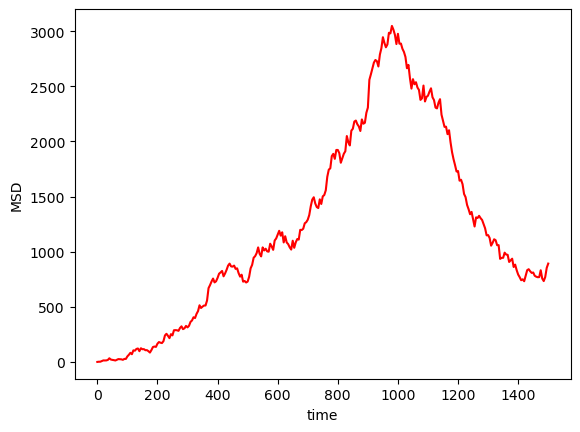

In [54]:
ddr = []
tdr = []

sel = 2

ddr.append(0)
tdr.append(0)

for j in range(0,sel):
    for i in range(1,len(x_diffs_rand_all[0])):
        if (j==0):
            tdr.append(i)
            ddr.append(x_diffs_rand_all[j][i]**2 + y_diffs_rand_all[j][i]**2)
        else:
            ddr[i]+=x_diffs_rand_all[j][i]**2 + y_diffs_rand_all[j][i]**2
            
for i in range(0,len(ddr)):    
    ddr[i] = ddr[i]/sel
    
    
dd = [[0]]#,[0],[0],[0],[0],[0],[0],[0]]
td = [0]

sel = 2

for z in range(0,1):
    for j in range(0,sel):
        for i in range(1,len(x_diffs_all[0][0])):
            if (j==0):
                if (z == 0):
                    td.append(i*5)
                dd[z].append(x_diffs_all[j][z][i]**2 + y_diffs_all[j][z][i]**2)
            else:
                dd[z][i]+=x_diffs_all[j][z][i]**2 + y_diffs_all[j][z][i]**2
            
    for i in range(0,len(dd[z])):    
        dd[z][i] = dd[z][i]/sel
    
    plt.plot(td, dd[z][:], 'r');

#plt.plot(tdr, ddr, 'b');

plt.xlabel("time");
plt.ylabel("MSD");

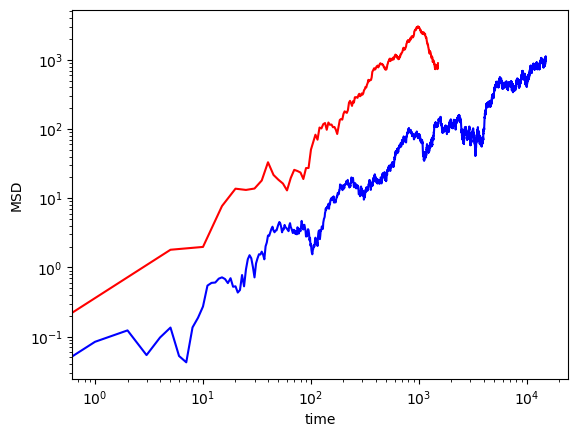

In [55]:
for z in range(0,1):
    plt.loglog(td, dd[z][:], 'r');
plt.loglog(tdr, ddr, 'b');

plt.xlabel("time");
plt.ylabel("MSD");

In [ ]:
import json

file = open('working_data_8x.json', 'w+')

for i in range(0,8):
    for j in range(0,len(x_diffs_all)):
        np.savetxt(file, x_diffs_all[j][i][:])
        np.savetxt(file, y_diffs_all[j][i][:])


In [11]:
file.close()

In [ ]:
    if (num_colloids == 1):
    
        c_x = [35]
        c_y = [35]

        x_centers = [[35]]
        y_centers = [[35]]
            
        x_diffs = [[0]]
        y_diffs = [[0]]
    
    elif (num_colloids == 2):
        
        c_x = [35, 35]
        c_y = [30, 40]

        x_centers = [[35],[35]]
        y_centers = [[30],[40]]
            
        x_diffs = [[0],[0]]
        y_diffs = [[0],[0]]
        
    elif (num_colloids == 4):
        if (arg_1 == 1):       
            c_x = [30, 40, 30, 40]
            c_y = [30, 40, 40, 30]

            x_centers = [[30],[40],[30],[40]]
            y_centers = [[30],[40],[40],[30]]
                

        if (arg_1 == 2):       
            c_x = [20, 50, 20, 50]
            c_y = [20, 50, 50, 20]

            x_centers = [[20],[50],[20],[50]]
            y_centers = [[20],[50],[50],[20]]
            
        if (arg_1 == 3):       
            c_x = [5, 20, 35, 50]
            c_y = [5, 20, 35, 50]

            x_centers = [[5],[20],[35],[50]]
            y_centers = [[5],[20],[35],[50]]
            
        if (arg_1 == 4):       
            c_x = [15, 45, 30, 60]
            c_y = [15, 15, 45, 45]

            x_centers = [[15],[45],[30],[60]]
            y_centers = [[15],[15],[45],[45]]
            
        x_diffs = [[0],[0],[0],[0]]
        y_diffs = [[0],[0],[0],[0]]
        
        x_diffs_save = [[0],[0],[0],[0]]
        y_diffs_save = [[0],[0],[0],[0]]

    
    elif (num_colloids == 8):
        c_x = [10, 35, 60, 20, 50, 10, 35, 60]
        c_y = [10, 10, 10, 35, 35, 60, 60, 60]

        x_centers = [[10], [35], [60], [20], [50], [10], [35], [60]]
        y_centers = [[10], [10], [10], [35], [35], [60], [60], [60]]
        
        x_diffs = [[0],[0],[0],[0],[0],[0],[0],[0]]
        y_diffs = [[0],[0],[0],[0],[0],[0],[0],[0]]